### Time Series Anomaly Detection using Artifical Neural Network

#### Introduction
Write an introduction of the project and a summary of anomaly detection.
describe the approach and the sources of the data.

In [1]:
# Import packages, describe them.
import numpy as np
import pandas as pd
import tensorflow.keras as keras
from matplotlib import pyplot as plt

In [74]:
#https://towardsdatascience.com/8-commonly-used-pandas-display-options-you-should-know-a832365efa95
pd.get_option('display.precision')

6

These are the data sources, describe these in both general and specific terms. What NAB and what used for.
https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv
https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv


In [34]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_no_anomaly = pd.read_csv(df_small_noise_url, parse_dates=True, index_col="timestamp")

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_anomaly = pd.read_csv(df_daily_jumpsup_url,parse_dates=True, index_col="timestamp") # note the inex is set as the timestamp so shape is 1.

Check the files vs what is on the web

In [35]:
df_no_anomaly.shape

(4032, 1)

In [65]:
pd.set_option('display.precision',6)

In [66]:
pd.reset_option('display.precision')
df_no_anomaly.describe()

,value
count,"4,032.0"
mean,42.438353335806646
std,28.077122281262515
min,18.0009640187
25%,19.84139024305
50%,21.6084867582
75%,75.45028165555
max,87.97612832639999


In [72]:
df_no_anomaly.iloc[0:2]["value"]

timestamp
2014-04-01 00:00:00   18.3249185392
2014-04-01 00:05:00    21.970327182
Name: value, dtype: float64

In [80]:
df_no_anomaly.iloc[0:5].values[0:5]

array([[18.32491854],
       [21.97032718],
       [18.62480603],
       [21.95368398],
       [21.90911973]])

In [48]:
df_no_anomaly.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [44]:
df_no_anomaly.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [38]:
df_daily_anomaly.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


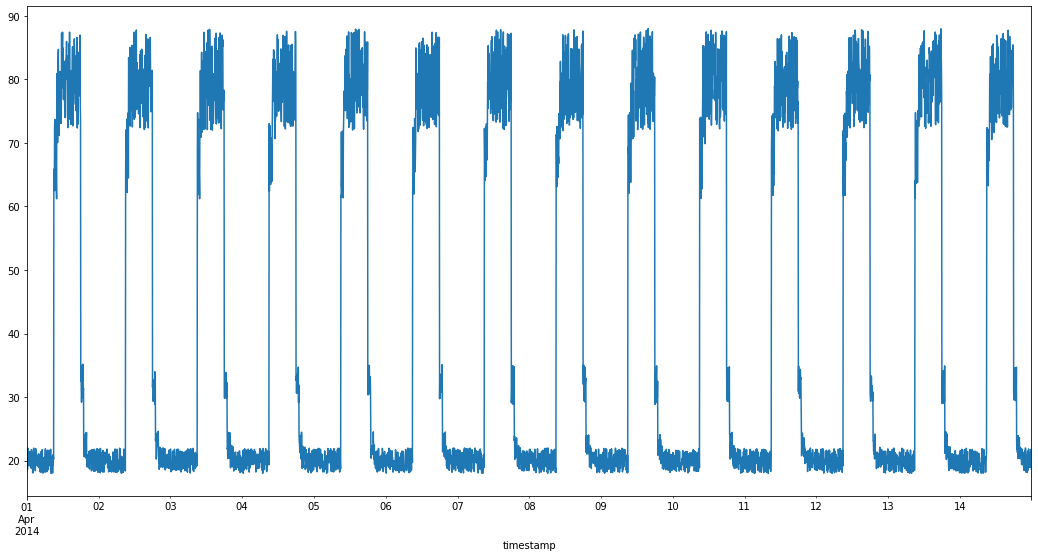

In [5]:
#Have a look at the plot of the small noise file. Hvae a look at using seaborn
fig, ax = plt.subplots(figsize=(18,9))
df_no_anomaly.plot(legend=False, ax=ax);

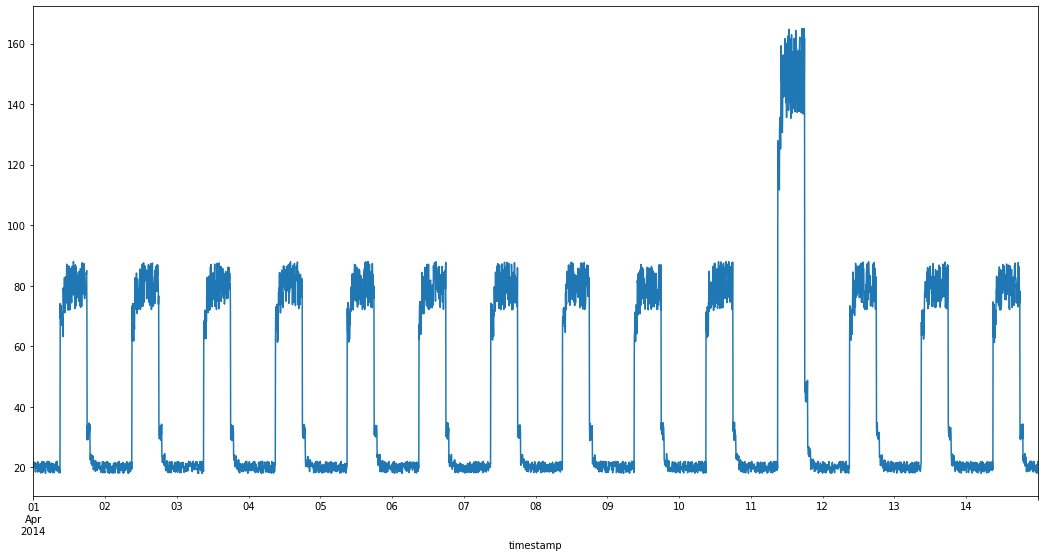

In [6]:
#Have a look at the plot of the small noise file with the anomaly.
fig, ax = plt.subplots(figsize=(18,9))
df_daily_anomaly.plot(legend=False, ax=ax);

### Preprocessing

In [7]:
# Normalize and save the mean and std.
#Variable for the mean of the small noise data set
training_mean = df_no_anomaly.mean()

#Variable for the std deviation of the small noise data set
training_std = df_no_anomaly.std()

#Calculate the training value(small noise value - mean/std deviation)
df_training_value = (df_no_anomaly - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [8]:
training_mean

value    42.438353
dtype: float64

In [9]:
training_std

value    28.077122
dtype: float64

In [10]:
df_training_value

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173
...,...
2014-04-14 23:35:00,-0.791647
2014-04-14 23:40:00,-0.780255
2014-04-14 23:45:00,-0.833640


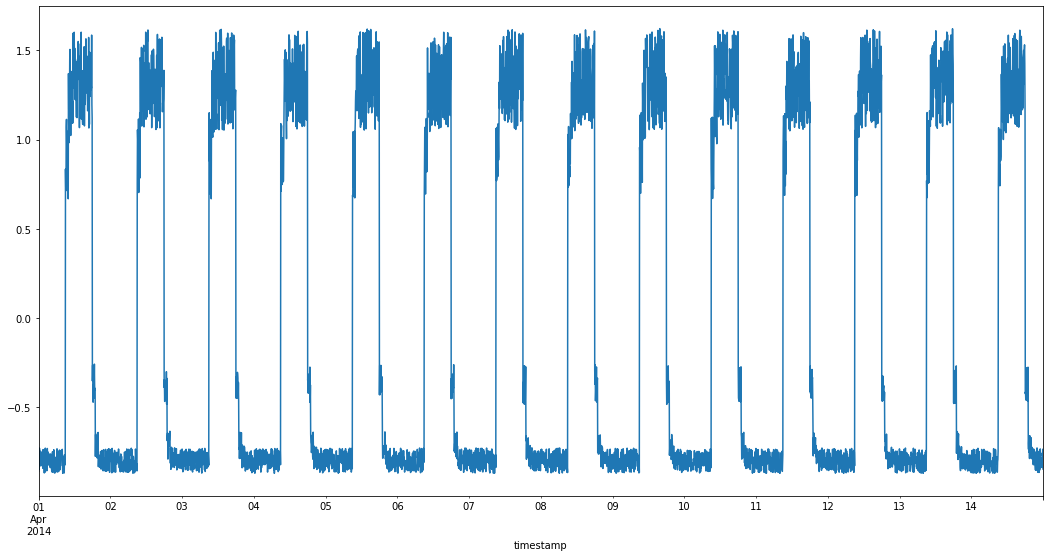

In [11]:
#Have a look at the training data. 
fig, ax = plt.subplots(figsize=(18,9))
df_training_value.plot(legend=False, ax=ax);


In [12]:
time_steps = 288

# Generated training sequences for use in the model.
def create_windows(values, time_steps=time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_windows(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


In [13]:
x_train

array([[[-0.85882857],
        [-0.72899302],
        [-0.84814772],
        ...,
        [-0.86453747],
        [-0.81250829],
        [-0.79671155]],

       [[-0.72899302],
        [-0.84814772],
        [-0.72958579],
        ...,
        [-0.81250829],
        [-0.79671155],
        [-0.78767946]],

       [[-0.84814772],
        [-0.72958579],
        [-0.731173  ],
        ...,
        [-0.79671155],
        [-0.78767946],
        [-0.73706287]],

       ...,

       [[-0.8226548 ],
        [-0.86660975],
        [-0.82181363],
        ...,
        [-0.79164661],
        [-0.78025492],
        [-0.83364049]],

       [[-0.86660975],
        [-0.82181363],
        [-0.75595835],
        ...,
        [-0.78025492],
        [-0.83364049],
        [-0.73510213]],

       [[-0.82181363],
        [-0.75595835],
        [-0.74256753],
        ...,
        [-0.83364049],
        [-0.73510213],
        [-0.8460886 ]]])

In [14]:
#Redo the  the layers, and add in comments on what they are.
#Figure out what they all mean.

layers = []

### Build the Neural network

In [15]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        keras.layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        keras.layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

In [16]:
# Explain what this is, model.fit
#https://keras.io/api/models/model_training_apis/
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 3s 96ms/step - loss: 0.5165 - val_loss: 0.1037
Epoch 2/50
27/27 [==============================] - 2s 90ms/step - loss: 0.0847 - val_loss: 0.0422
Epoch 3/50
27/27 [==============================] - 2s 89ms/step - loss: 0.0608 - val_loss: 0.0358
Epoch 4/50
27/27 [==============================] - 2s 85ms/step - loss: 0.0510 - val_loss: 0.0298
Epoch 5/50
27/27 [==============================] - 2s 84ms/step - loss: 0.0441 - val_loss: 0.0270
Epoch 6/50
27/27 [==============================] - 2s 84ms/step - loss: 0.0391 - val_loss: 0.0249
Epoch 7/50
27/27 [==============================] - 2s 87ms/step - loss: 0.0353 - val_loss: 0.0215
Epoch 8/50
27/27 [==============================] - 2s 88ms/step - loss: 0.0319 - val_loss: 0.0206
Epoch 9/50
27/27 [==============================] - 2s 87ms/step - loss: 0.0292 - val_loss: 0.0189
Epoch 10/50
27/27 [==============================] - 2s 87ms/step - loss: 0.0272 - val_loss: 0.0180
Epoch 11/

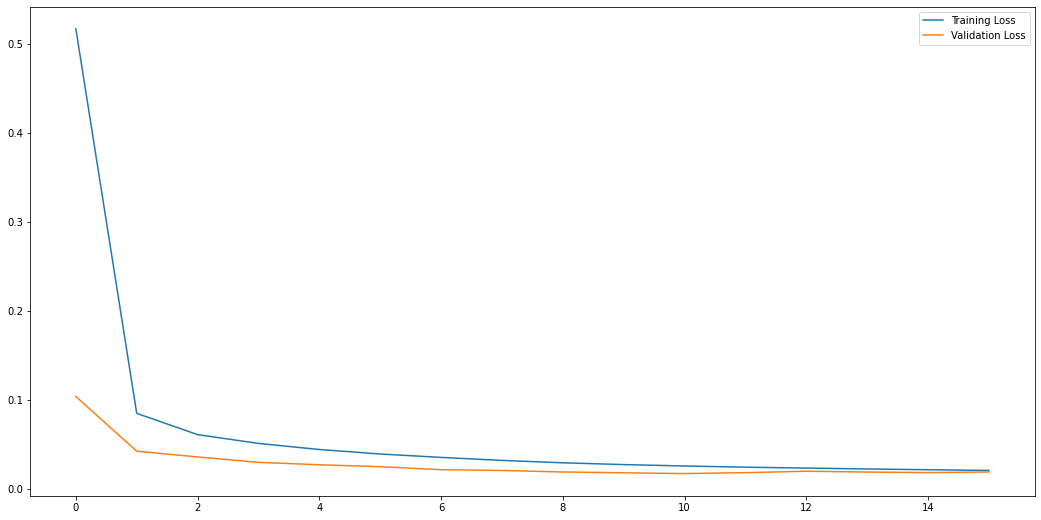

In [17]:
#Get information on model.fit history.
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.figure(figsize=(18,9))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend();

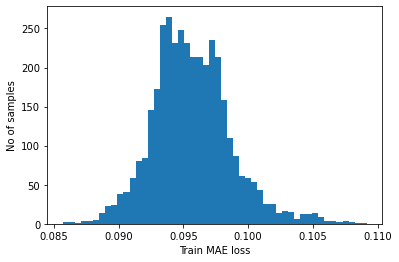

Reconstruction error threshold:  0.10915534935419818


In [18]:
# Get train MAE loss. What is this.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

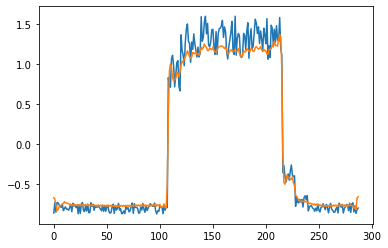

In [19]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0]);

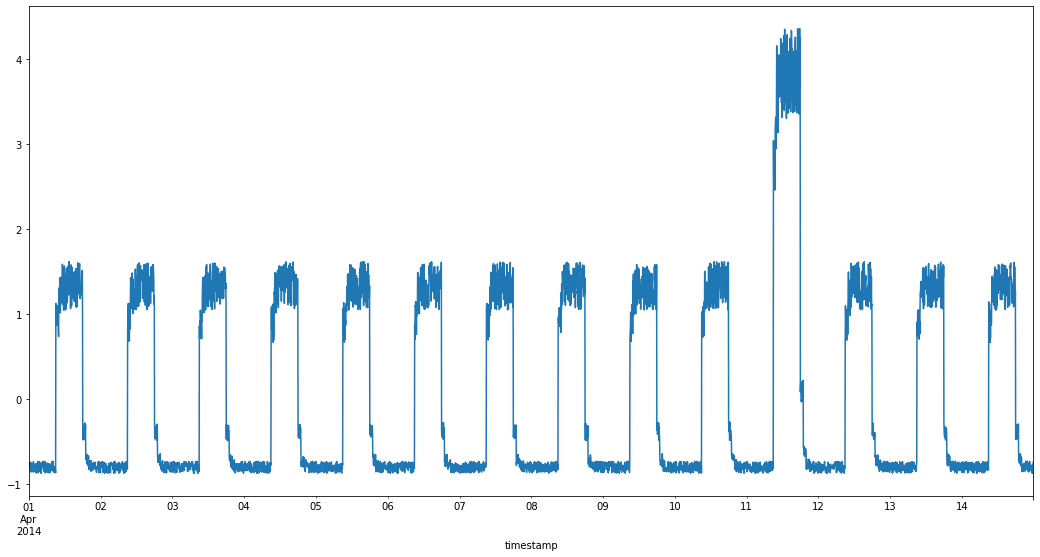

Test input shape:  (3745, 288, 1)


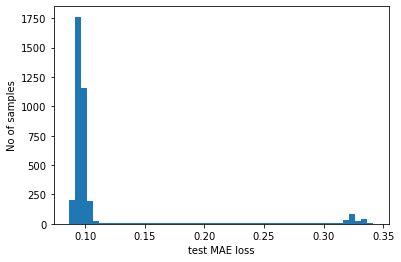

Number of anomaly samples:  402
Indices of anomaly samples:  (array([ 787,  790, 1651, 1653, 1654, 2516, 2518, 2522, 2702, 2703, 2704,
       2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715,
       2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726,
       2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737,
       2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748,
       2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759,
       2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770,
       2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781,
       2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792,
       2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803,
       2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814,
       2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825,
       2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2

In [20]:

#Break all of this to explain and demonstrate.
df_test_value = (df_daily_anomaly - training_mean) / training_std
fig, ax = plt.subplots(figsize=(18,9))
df_test_value.plot(legend=False, ax=ax);
plt.show()

# Create sequences from test values.
x_test = create_windows(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [21]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
#https://www.sharpsightlabs.com/blog/numpy-all/

anomalous_data_indices = []
for data_idx in range(time_steps - 1, len(df_test_value) - time_steps + 1):
    if np.all(anomalies[data_idx - time_steps + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [22]:
df_subset = df_daily_anomaly.iloc[anomalous_data_indices]
df_subset

,value
timestamp,
2014-04-11 09:05:00,115.705719
2014-04-11 09:10:00,122.386410
2014-04-11 09:15:00,127.261178
2014-04-11 09:20:00,121.157997
2014-04-11 09:25:00,120.468468
...,...
2014-04-11 17:40:00,156.009099
2014-04-11 17:45:00,164.947481
2014-04-11 17:50:00,145.758267


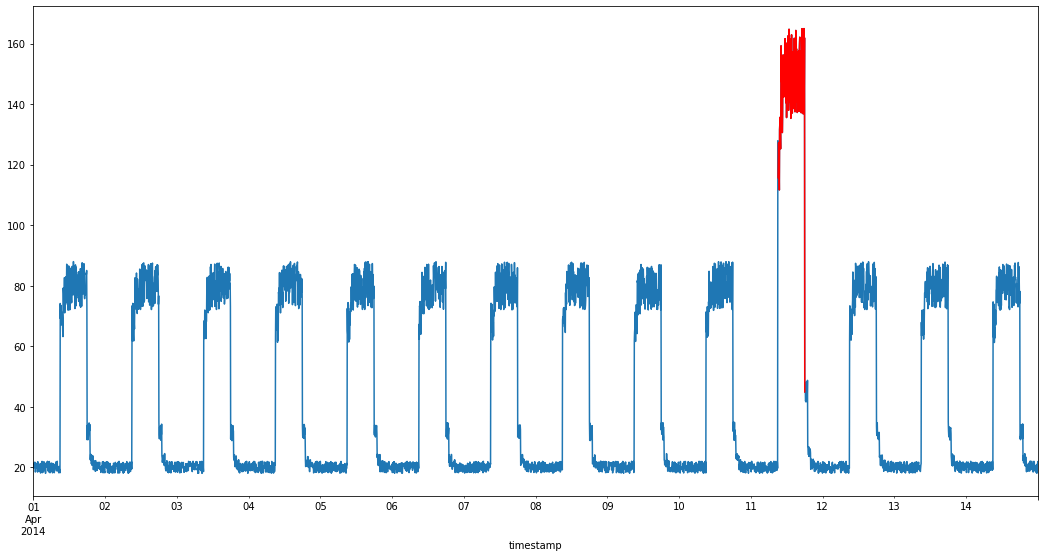

In [23]:
fig, ax = plt.subplots(figsize=(18,9))
df_daily_anomaly.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show;